# 剪枝与量化结合

<!-- ## 前提条件

1. 建议创建虚拟环境
2. 配置基础环境依赖
3. 如果有支持CUDA的GPU, 加入 -->

## 准备
1. 数据集：**CIFAR-10**
>CIFAR-10 数据集是机器学习和计算机视觉中广泛使用的基准测试，由 60,000 张 32x32 彩色图像组成，分为 10 个类别，每个类别有 6,000 张图像。
2. 预训练模型： **ResNet18**
>残差神经网络（也称为残差网络或 ResNet）是一种开创性的深度学习模型，其中权重层参考层输入学习残差函数。它于 2015 年开发用于图像识别，并赢得了当年的 ImageNet 大规模视觉识别挑战赛 （ILSVRC）。
对于ResNet-18的模型结构可视化和其他信息，可以参考李沐老师的[d2l](https://d2l.ai/chapter_convolutional-modern/resnet.html)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.utils.prune as prune
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader
from torchvision.models import ResNet18_Weights
from torchsummary import summary
from torchprofile import profile_macs

import os
import random
import copy
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from typing import Dict, List
from timeit import default_timer as timer

device = "cuda" if torch.cuda.is_available() else "cpu"

### 载入数据集

Files already downloaded and verified
Files already downloaded and verified
分类： ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


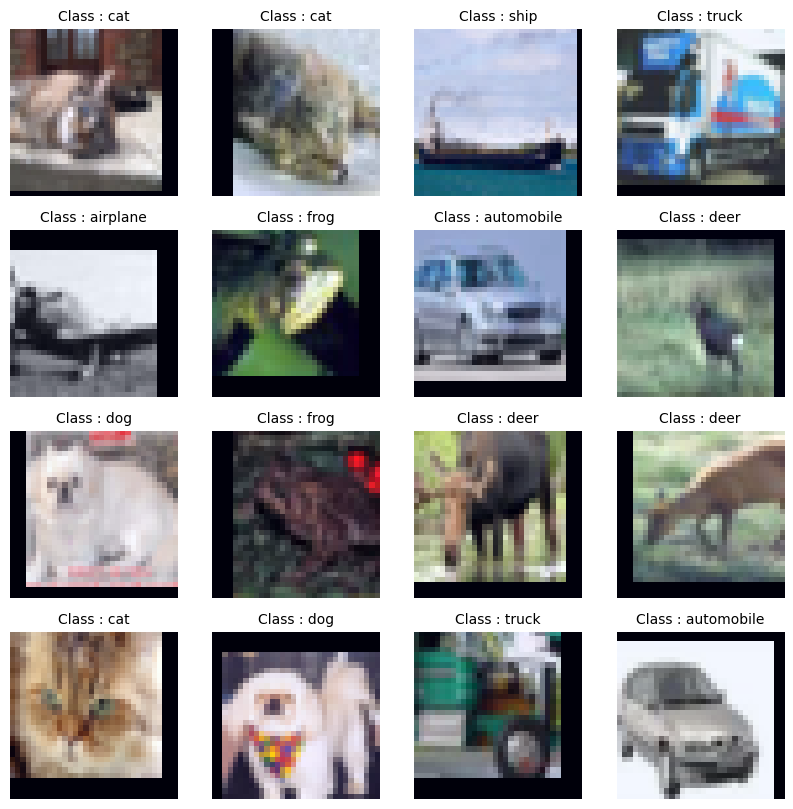

In [2]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 512

# 载入并归一化 CIFAR-10，并对训练集进行数据增强
transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

# 将数据集划分为训练集和测试集
train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
train_loader = DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
test_loader = DataLoader(
    test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)


def visual_data(dataset):
    class_names = dataset.classes
    print("分类：", class_names)
    rand_idx = random.sample(range(len(dataset)), k=16)

    plt.figure(figsize=(10, 10))

    for i, idx in enumerate(rand_idx):
        img, label = dataset[idx]
        img = (img - img.min()) / (img.max() - img.min())
        img_class = class_names[label]

        plt.subplot(4, 4, i + 1)
        plt.imshow(img.permute(1, 2, 0))
        plt.title(f"Class : {img_class}", fontsize=10)
        plt.axis(False)


# 数据可视化
visual_data(train_set)

### 训练模型（可选）

训练模型的硬件要求较高，建议在GPU环境下进行训练，或者使用colab。如果您的设备不支持GPU，可以跳过这一步，直接使用我们提供的预训练模型。


In [3]:
# 超参
NUM_EPOCHS = 120
CHECKPOINT_EVERY = 10

CONTINUE = True

model_0 = torchvision.models.resnet18().to(device)
checkpoint_dir = "./model/"
checkpoint_path = os.path.join(checkpoint_dir, "resnet18_checkpoint.ckpt")
best_model_path = os.path.join(checkpoint_dir, "resnet18_best.pt")
results_path = os.path.join(checkpoint_dir, "results.pkl")

learning_rate = 0.005
weight_decay = 5e-4
grad_clip = 0.005
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model_0.parameters(), lr=learning_rate, weight_decay=weight_decay
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, mode="min", factor=0.3, patience=2, threshold=8e-3, cooldown=2
)
accuracy_record = 0.0

In [4]:
def save_checkpoint(epoch, model, optimizer, scheduler, accuracy, path):
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "accuracy": accuracy,
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved at epoch {epoch+1} to {path}")


def load_checkpoint(path, model, optimizer, scheduler):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    accuracy = checkpoint["accuracy"]
    start_epoch = checkpoint["epoch"] + 1
    print(
        f"Checkpoint loaded from {path}, starting from epoch {start_epoch} with accuracy {accuracy:.4f}"
    )
    return start_epoch, accuracy


def train_step(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn: nn.Module,
    optimizer: optim.Optimizer,
    scheduler: optim.lr_scheduler = None,
    grad_clip: float = None,
):
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        if grad_clip:
            nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        optimizer.step()
        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y)

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    if scheduler is not None:
        scheduler.step(train_loss)

    return train_loss, train_acc


def test_step(model: nn.Module, dataloader: DataLoader, loss_fn: nn.Module = None):
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            if loss_fn is None:
                test_loss = None
            else:
                loss = loss_fn(test_pred_logits, y)
                test_loss += loss.item()
            test_pred_labels = torch.argmax(test_pred_logits, dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(y)

        if loss_fn is not None:
            test_loss /= len(dataloader)
        test_acc /= len(dataloader)

    return test_loss, test_acc


def train(
    model: nn.Module,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    optimizer: optim.Optimizer,
    scheduler: optim.lr_scheduler,
    grad_clip: float = None,
    loss_fn: nn.Module = nn.CrossEntropyLoss(),
    epochs: int = 10,
    start_epoch: int = 0,
    results: Dict[str, List[float]] = None,
):
    global accuracy_record
    if results is None or start_epoch == 0:
        # 重新开始训练，初始化results
        results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in tqdm(range(start_epoch, epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            scheduler=scheduler,
            grad_clip=grad_clip,
        )
        test_loss, test_acc = test_step(
            model=model, dataloader=test_dataloader, loss_fn=loss_fn
        )
        # 记录最佳模型
        if test_acc > accuracy_record + 0.001:
            torch.save(model.state_dict(), best_model_path)
            accuracy_record = test_acc
            print(f"最佳模型更新，现在的最高准确度： {accuracy_record:.4f}")
        # 记录checkpoint
        if (epoch + 1) % CHECKPOINT_EVERY == 0:
            save_checkpoint(
                epoch, model, optimizer, scheduler, accuracy_record, checkpoint_path
            )
        # 记录每轮训练的结果
        print(
            f"Epoch: {epoch+1} | "
            f"lr: {optimizer.param_groups[0]['lr']:.4f} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        if train_acc > 0.99 and test_acc < 0.8:
            print("可能过拟合，提前停止训练")
            break

    return results


def plot_loss_curves(results: Dict[str, List[float]]):
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]
    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.grid()
    plt.legend()

    # accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.grid()
    plt.legend()

In [5]:
start_time = timer()

# 加载模型(最近的checkpoint)
start_epoch = 0
if CONTINUE and os.path.exists(checkpoint_path) and os.path.exists(results_path):
    start_epoch, accuracy_record = load_checkpoint(
        checkpoint_path, model_0, optimizer, scheduler
    )
if os.path.exists(best_model_path):
    record = torchvision.models.resnet18()
    record.load_state_dict(torch.load(best_model_path, weights_only=True))
    record.to(device)
    accuracy_record = max(accuracy_record, test_step(record, test_loader)[1])
    print(f"Best model loaded with accuracy {accuracy_record:.4f}")

# 开始训练
model_0_results = train(
    model=model_0,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    grad_clip=grad_clip,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    start_epoch=start_epoch,
)

end_time = timer()
print(f"Training time: {end_time - start_time:.3f} seconds")

# 保存训练结果到pickle文件
with open(results_path, "wb") as f:
    pickle.dump(model_0_results, f)

Best model loaded with accuracy 0.8561


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 1 | lr: 0.0050 | train_loss: 1.8309 | train_acc: 0.3622 | test_loss: 1.7330 | test_acc: 0.4026
Epoch: 2 | lr: 0.0050 | train_loss: 1.3683 | train_acc: 0.5028 | test_loss: 1.4013 | test_acc: 0.4926
Epoch: 3 | lr: 0.0050 | train_loss: 1.1984 | train_acc: 0.5713 | test_loss: 1.2500 | test_acc: 0.5463
Epoch: 4 | lr: 0.0050 | train_loss: 1.0936 | train_acc: 0.6145 | test_loss: 1.4054 | test_acc: 0.5042
Epoch: 5 | lr: 0.0050 | train_loss: 1.0212 | train_acc: 0.6413 | test_loss: 1.0652 | test_acc: 0.6240
Epoch: 6 | lr: 0.0050 | train_loss: 0.9581 | train_acc: 0.6660 | test_loss: 1.2499 | test_acc: 0.5748
Epoch: 7 | lr: 0.0050 | train_loss: 0.9095 | train_acc: 0.6868 | test_loss: 0.9478 | test_acc: 0.6698
Epoch: 8 | lr: 0.0050 | train_loss: 0.8647 | train_acc: 0.7035 | test_loss: 1.0734 | test_acc: 0.6325
Epoch: 9 | lr: 0.0050 | train_loss: 0.8368 | train_acc: 0.7132 | test_loss: 0.9662 | test_acc: 0.6664
Checkpoint saved at epoch 10 to ./model/resnet18_checkpoint.ckpt
Epoch: 10 | lr: 0

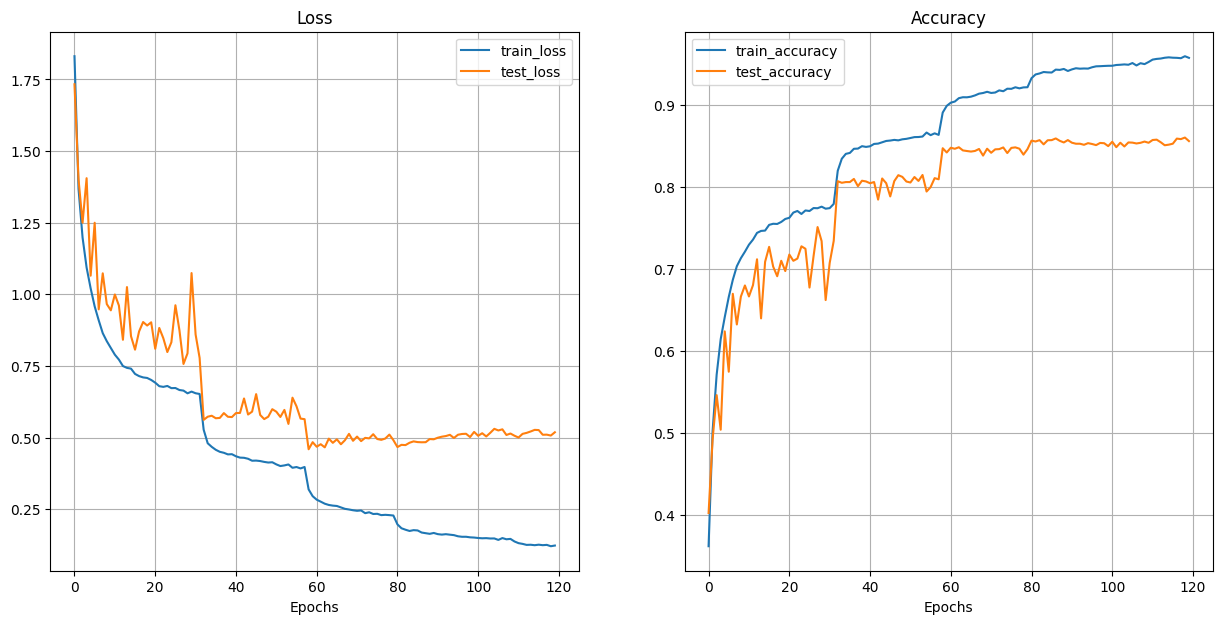

In [6]:
plot_loss_curves(model_0_results)

### 载入预训练模型

In [7]:
resnet18 = torchvision.models.resnet18()

# 加载预训练模型
model_path = "./model/resnet18_best.pt"
resnet18.load_state_dict(torch.load(model_path, weights_only=True))
resnet18 = resnet18.to(device)

# ResNet-18模型结构
summary(resnet18, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [8]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements


def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    return get_num_parameters(model, count_nonzero_only) * data_width


Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB


@torch.no_grad()
def get_model_info(model: nn.Module, unit: int = MiB) -> Dict[str, float]:
    model.eval()
    return {
        "macs": get_model_macs(model, torch.randn(1, 3, 32, 32).to(device)) / unit,
        "parameters": get_num_parameters(model) / unit,
        "size": get_model_size(model) / unit,
        "sparsity": get_model_sparsity(model),
        "accuracy": test_step(model, test_loader)[1],
    }


def plot_model_infos(models_infos: List[Dict[str, float]], names: List[str] = None):
    metrics = list(models_infos[0].keys())
    num_metrics = len(metrics)
    num_models = len(models_infos)
    if names is None:
        names = [f"Model {i+1}" for i in range(num_models)]

    fig, axes = plt.subplots(1, num_metrics, figsize=(15, 5), sharey=False)

    for idx, metric in enumerate(metrics):
        values = [model_info[metric] for model_info in models_infos]

        x_pos = np.arange(num_models)

        bars = axes[idx].bar(x_pos, values, align="center", alpha=0.7)
        axes[idx].set_title(metric.capitalize())
        axes[idx].set_xticks(x_pos)
        axes[idx].set_xticklabels(names, rotation=45)
        axes[idx].set_ylabel(metric)

        for bar, value in zip(bars, values):
            axes[idx].text(
                bar.get_x() + bar.get_width() / 2.0,
                bar.get_height(),
                f"{value:.3f}",
                ha="center",
                va="bottom",
            )

    plt.tight_layout()
    plt.show()

In [9]:
orign_info = get_model_info(resnet18)
print(orign_info)

{'macs': 4.479248046875, 'parameters': 1.393498420715332, 'size': 44.591949462890625, 'sparsity': 8.554677046745951e-07, 'accuracy': 0.8472828584558825}


## 剪枝和量化结合


### 剪枝与量化相关函数

#### 关于剪枝方法的选择

首先，pytorch提供的两种常用剪枝方法（结构化L2范数剪枝，和使用非结构化L1范数剪枝）：

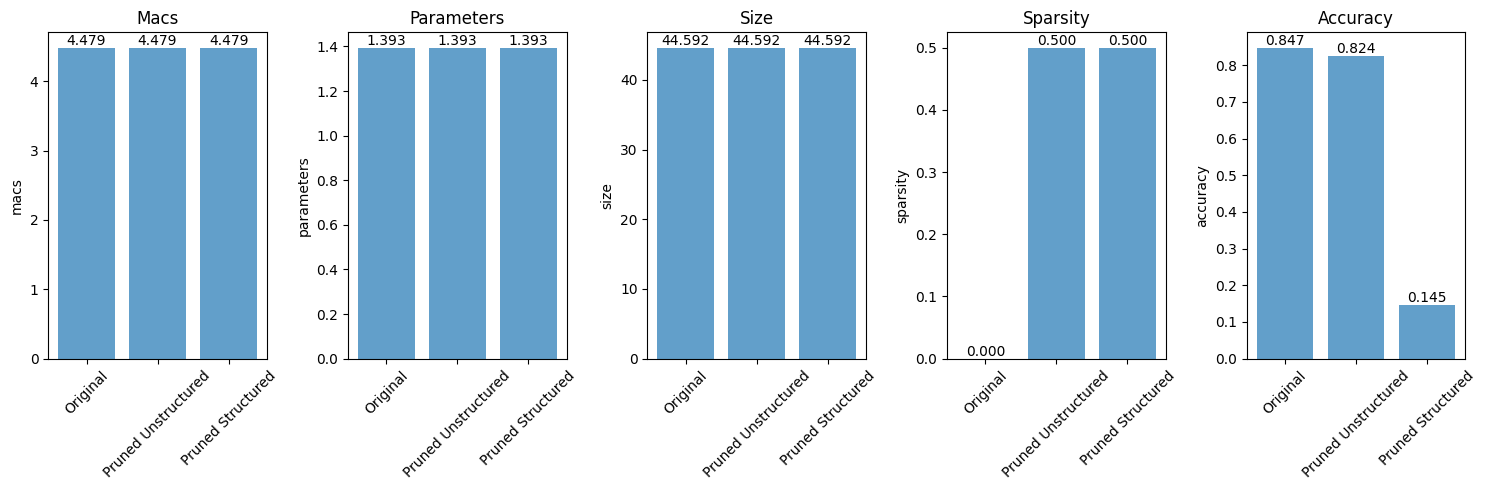

In [10]:
@torch.no_grad()
def prune_simple(model, pruning_rate=0.1, structured=False):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            if structured:
                # 使用结构化L2范数剪枝
                prune.ln_structured(
                    module, name="weight", amount=pruning_rate, n=2, dim=0
                )
                prune.remove(module, "weight")
            else:
                # 使用非结构化L1范数剪枝
                prune.l1_unstructured(module, name="weight", amount=pruning_rate)
                prune.remove(module, "weight")


model_pruned_u = copy.deepcopy(resnet18)
model_pruned_s = copy.deepcopy(resnet18)
prune_simple(model_pruned_u, pruning_rate=0.5, structured=False)
prune_simple(model_pruned_s, pruning_rate=0.5, structured=True)
pruned_u_info = get_model_info(model_pruned_u)
pruned_s_info = get_model_info(model_pruned_s)
plot_model_infos(
    [orign_info, pruned_u_info, pruned_s_info],
    names=["Original", "Pruned Unstructured", "Pruned Structured"],
)

注意到，这两种剪枝方法都是把权重设置为零，没有直接减小模型的计算量（MACs）和大小（Parameters），需要合适的调度层和硬件层的稀疏加速，以及权重矩阵的稀疏表示。
直接删除模型部分结构可以直接减小模型的计算量和大小，但是需要考虑结构之间的依赖关系，结构化剪枝的方法可以参考[Torch-Pruning](https://github.com/VainF/Torch-Pruning)。

### 量化相关函数

In [11]:
q_config = "tensorrt" if torch.cuda.is_available() else "x86"
# 自定义量化配置
# quantization_config = torch.quantization.default_qconfig
# quantization_config = torch.quantization.QConfig(activation=torch.quantization.MinMaxObserver.with_args(dtype=torch.quint8), weight=torch.quantization.MinMaxObserver.with_args(dtype=torch.qint8, qscheme=torch.per_tensor_symmetric))


@torch.no_grad()
def quantize_simple(model, data_loader, device, q_config):
    model.to(device)
    model.eval()
    fused_model = copy.deepcopy(model)
    fused_model.eval()
    fused_model = torch.quantization.fuse_modules(
        fused_model, [["conv1", "bn1", "relu"]], inplace=True
    )
    for module_name, module in fused_model.named_children():
        if "layer" in module_name:
            for basic_block_name, basic_block in module.named_children():
                torch.quantization.fuse_modules(
                    basic_block,
                    [["conv1", "bn1", "relu1"], ["conv2", "bn2"]],
                    inplace=True,
                )
                for sub_block_name, sub_block in basic_block.named_children():
                    if sub_block_name == "downsample":
                        torch.quantization.fuse_modules(
                            sub_block, [["0", "1"]], inplace=True
                        )
    fused_model.qconfig = torch.quantization.get_default_qconfig(q_config)
    print(fused_model.qconfig)
    model_prepared = torch.quantization.prepare(fused_model)

    # Calibration
    for inputs, _ in data_loader:
        inputs = inputs.to(device)
        model_prepared(inputs)
    model_quantized = torch.quantization.convert(model_prepared)

    return model_quantized

### 量化

In [12]:
# 将模型量化为int8类型
resnet18_int8 = torch.quantization.convert(resnet18, inplace=False)

# 保存量化后的模型
# torch.save(resnet18_int8.state_dict(), 'resnet18_int8.pth')

# 加载并评估量化后的模型
resnet18_int8_loaded = torchvision.models.resnet18()
resnet18_int8_loaded.qconfig = torch.quantization.get_default_qconfig("fbgemm")
resnet18_int8_loaded = torch.quantization.prepare(resnet18_int8_loaded)
resnet18_int8_loaded = torch.quantization.convert(resnet18_int8_loaded)
resnet18_int8_loaded.load_state_dict(torch.load("resnet18_int8.pth"))

/home/tony/miniconda3/envs/pt11.8/lib/python3.10/site-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/home/tony/miniconda3/envs/pt11.8/lib/python3.10/site-packages/torch/ao/quantization/observer.py:1315: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(
/tmp/ipykernel_4792/1228154997.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be fli

FileNotFoundError: [Errno 2] No such file or directory: 'resnet18_quantized.pth'